Analysis of eye tracking files from Spiro study.
Gaze dispersion metric based on Christoforou et al, 2015: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4428128/pdf/fpsyg-06-00579.pdf
The objective is as follows:
(1) compute within-subject dispersion metric, based on short sections of the film (250 ms with 50 ms shift, ie 80% overlap)
(2) get sections with extreme dispersion score


In [61]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

Utils

In [2]:
from scipy.stats import norm
# get participant numbers

def get_pnums(infiles):
    """
    Get participant numbers from filenames.

    Parameters
    ----------
    infiles: array of input file names

    Returns
    -------
    list of participant numbers 
    """
    id = []
    for i,filenames in enumerate(infiles):
        pnum = [int(s) for s in filenames.split('_') if s.isdigit()]
        id.append([pnum])

def flatten(list_name):
    """ 
    Function that flattens list of lists.

    Parameters
    ----------
    list_name: str
        Name of the list to flatten
    
    Returns
    -------
    Flattened list
    """
    flattened = [item for sublist in list_name for item in sublist]
    return flattened

def get_random_samps(df, frame_num_max, id):
    """ 
    Fit a participant's gaze data to normal distribution.
    Randomly sample normal distribution with participant-specific mean and std.

    Parameters
    ----------
    df: pandas dataframe
        dataframe holding eye tracking data from all participants

    frame_num_max: int
        maximum number of frames for participant,
        will be used to determine how many samples to draw

    id: int
        participant id 
    
    Returns
    -------
    Simulated gaze data in x and y.

    """
    # first, let's simulate some gaze data.
    # some basic parameters
    #gaze_length = df.frame_num.max() # number of samples we need to generate
    mux,stdx = norm.fit(df.loc[df.id == id,'gaze_in_x'])
    muy,stdy = norm.fit(df.loc[df.id == id, 'gaze_in_y'])
    # get samples
    sim_in_x = norm.rvs(loc = mux, scale = stdx, size = frame_num_max)
    sim_in_y = norm.rvs(loc = muy, scale = stdy, size = frame_num_max)
    return sim_in_x, sim_in_y

def calculate_dispersion_scores(frame_num, gaze_x, gaze_y,window_size, window_step):
    """
    Calculate dispersion scores for each window.

    Parameters
    ----------
    frame_num: array
        frame number
    gaze_x, gaze_y: pandas DataFrame
        gaze positions in x and y
    window_size: int
        size of window (how many frames)
    window_step: int
        number of frames to move each time the window slides
        (ie overlap between windows)
    
    Returns
    -------
    list containing mean score per window
    """
    dists = []
    for i in frame_num:
        frame_df = pd.concat([gaze_x.loc[i,:],gaze_y.loc[i,:]],axis = 1)
        frame_dist_val =  np.unique(pairwise_distances(frame_df.dropna(),
                            frame_df.dropna(),force_all_finite = True)).mean()
        dists.append(frame_dist_val)

     # now we calculate the mean euclidean distance for each window.
    steps = np.arange(0,len(dists)-15,window_step)

    # now calculate the mean for each 15-frame window (corresponds to ~250 ms)
    # with a step size of 3 (80% overlap between successive windows)
    wind_dists = []
    for i in steps:
        wind_dist = np.array(dists)[i:i+window_size].mean()
        wind_dists.append(wind_dist)
    wind_dists = pd.Series(wind_dists)
    return wind_dists

def get_consec_sections2(divergent_winds_numwinds):
    """
    Find consecutive sections of divergent windows.
    This should be faster than the other version.
    Timeit says it's not.
    
    Parameters
    ----------
    divergent_winds_numwinds: iterable
        Iterable representing the window numbers
        of windows identified as divergent
    
    Returns
    -------
    list of window numbers at which a break in 
    consecutive values was detected.
    """
    index_break = [f for i,f in enumerate(divergent_winds_numwinds)
                    if (i>0) & (f > divergent_winds_numwinds[i-1]+1)]

    return index_break

def get_consec_sections(divergent_winds_numwinds):
    """
    Find consecutive sections of divergent windows.

    Parameters
    ----------
    divergent_winds_numwinds: iterable
        Iterable representing the window numbers
        of windows identified as divergent
    
    Returns
    -------
    list of window numbers at which a break in 
    consecutive values was detected.

    """
    index_break = []
    for i,window in enumerate(divergent_winds_numwinds):
        if i==0:
            wind = window
        elif (i>0) & (window-wind > 1):
            index_break.append(window)
            wind = window
        else:
            wind = window 
    return index_break

def get_frame_nums(index_break,step,wind):
    """
    Get first and last frame for divergent windows.

    Parameters
    ----------
    index_break:   iterable
        iterable containing start indices of each
        non-consecutive batch of divergent windows
        (I know, sorry)
    step:   int
        step size used for window calculation
    wind:   int
        number of frames in each window
    
    Returns
    -------
    list of tuples
    start/stop frame for each divergent section
    """
    start_and_stop = list(zip(index_break[:-1], [i-1 for i in index_break[1:]]))
    frame_nums = [(start*step+wind,stop*step+wind)
                for start,stop in start_and_stop]

    return frame_nums


def calculate_iGDI(dispersion_scores, mean_sim_score):
    """
    Calculate the eye gaze divergence index (iGDI)
    Proportion of divergent windows across film viewings

    Parameters
    ----------
    dispersion_scores:  pd.Series
        dispersion scores for each window
    mean_sim_score: float
        mean dispersion score across all
        simulated windows

    Returns
    ------- 
    divergent_windows:
        Binary array indicating whether a given window was
        classed as divergent or not
    
    iGDI_score:
        Proportion of windows classed as divergent
        (ie eye gaze divergence index)

    """
    divergent_windows = np.zeros(len(dispersion_scores))

    for i,disp_score in enumerate(dispersion_scores):
        if disp_score>mean_sim_score:
            divergent_windows[i]=1
        else:
            continue
    
    iGDI_score = sum(divergent_windows)/len(dispersion_scores)
    return iGDI_score, divergent_windows
    
def substring_in_df_col(df,substrings):
    """
    filter pandas dataframe using
    multiple substrings

    Parameters
    ----------
    df: pandas DataFrame
        input dataframe to filter
    substrings: iterable
        (typically) list of
        substrings of interest
    
    Returns
    -------
    Filtered dataframe
    """
    colnames = df.columns
    out_cols = [col for col in colnames
                for substr in substrings
                if substr in col]
    
    out_df = df.loc[:,out_cols]
    return out_df

def remove_start_secs(frame_numbers:list, threshold:tuple):
    """
    remove "Scene 1" and "Scene 2" display
    sections.

    Parameters
    ----------
    len_frames: list
        number of frames in each stretch of consecutive
        divergent windows
    threshold:  tuple(int, int)
        start and end of window of frame numbers to ignore
    
    Returns
    -------
    len_frames with windows falling into threshold replaced with 0
    
    """
    masked_len_frames = [(0,0) if (num1>threshold[0])&(num2<threshold[1])
                        else (num1,num2) for (num1,num2) in frame_numbers]
    return masked_len_frames

def remove_short_secs(frame_numbers, len_thresh):
    """
    Remove sections too short to be considered of interest.
    Given that the frame rate of the film is ~30 fps,
    30 frames is probably a reasonable threshold to use.

    Parameters
    ----------
    frame_numbers:  list of tuples
        start and stop frame of each section
        of consecutive windows
    len_thresh: int
        minimum number of frames in section
        to be considered of interest
    
    Returns
    -------
    list of frame numbers with sections not of interest
    masked with (0,0)
    """
    masked_frames = [(num1,num2)for num1,num2
                    in frame_numbers 
                    if (num2-num1>=len_thresh)]
    return masked_frames

def get_gaze_dat_sec(gaze_data_df, sec):
    """
    Get gaze point data for frame numbers
    within sec

    Parameters
    ----------
    gaze_data_df:   pd DataFrame
        gaze point data
    sec:    tuple(int,int)
        numer of first and last frames
        w/in section of interest

    Returns
    -------
    dataframe corresponding to gaze data w/in
    section of interest
    """
    gaze_sec_df = gaze_data_df.loc[(gaze_data_df.frame_num>=sec[0])&
                                    (gaze_data_df.frame_num<=sec[1]),
                                    ["id","gaze_in_x","gaze_in_y","frame_num"]]
    return gaze_sec_df

def calc_wind_avg_recur(gaze_dat_df,win_size, step_size, gaze_num = []):
    """
    Calulate mean gaze position w/in window

    Parameters
    ----------
    Returns
    -------
    """
    if gaze_dat_df.shape[0]<=win_size:
        gaze_num.append(gaze_dat_df.mean())
    else:
        gaze_num.append(gaze_dat_df.iloc[:15,:].mean())
        calc_wind_avg_recur(gaze_dat_df.iloc[step_size:,:],win_size,step_size,gaze_num = gaze_num)
    return gaze_num

def get_diff_rows_recur(iter_in,diffs = []):
    """
    Get difference between successive rows.

    Parameters
    ----------
    iter_in: iterable
        array containing sorted k nearest neighbors
        distances. Must be of 1xn dimensional for this
        to work.
    diffs:  list
        list to append differences between rows to.
    
    Returns
    -------
    Array of between-row differences (in reverse order).
        
    """
    if len(iter_in)<2:
        diffs.append(np.nan)
        return diffs
    else:
        diffs.append(iter_in[-1]-iter_in[-2])
        get_diff_rows_recur(iter_in[:-1],diffs = diffs)
    return diffs
        

(i) get time stamps from message file
- discard everything but the messages containing frame nr.
(ii) load data file and add column for frame nr
(iii) label rows between message (framenr) time stamps with the appropriate frame nr

In [3]:
home = 0
if home:
    rawfilepath = r"C:\Users\Luzia T\Eye-gaze-divergence"
    Tobii_files = [f for f in os.listdir(rawfilepath) if 'merged' in f]
    calibration_files = [f for f in os.listdir(rawfilepath) if 'calib' in f]
else:
    # first we need to establish where to find the files and read them in.
    rawfilepath = r"P:\Spironolactone\eye_tracking\Tobii"
    intrusions_dir = r"P:\Eye-gaze-divergence"
    # get merged Tobii files - these have both event info and eye gaze data.
    Tobii_files = [f for f in os.listdir(rawfilepath) if 'merged' in f]
    # get_calibration files
    calibration_files = [f for f in os.listdir(rawfilepath) if 'calib' in f and f.endswith('.tsv')]
    msg_files = [f for f in os.listdir(rawfilepath) if 'msg' in f and f.endswith('.tsv')]

In [4]:
# get pnum, left/right gaze point on display area, event messages 
# keep only columns between framenum 0 and the last frame
# set invalid samples to NaN (validity == 0)
frames = []
gaze_in_x = []
gaze_in_y = []
pnums = []

for i,filename in enumerate(Tobii_files):
    # read file
    tobii_file = pd.read_table(os.path.join(rawfilepath, filename))
    # get participant number and add as column
    tobii_file['pnum'] = np.repeat([int(s) for s in filename.split('_') if s.isdigit()], tobii_file.shape[0])
    # get row index of frame each frame presentation
    event_index = tobii_file.loc[tobii_file.msg.str.contains('FRAME',na = False),'msg'].index
    # drop everything before first frame index (ie frame 0) and after last frame
    tobii_file = tobii_file.loc[event_index[0]:event_index[-1],:]
    # extract frame number from event time stamps
    tobii_file.loc[event_index, 'msg'] = [f[0] for f in tobii_file.loc[event_index,'msg'].str.split(';', n = 1)]
    tobii_file['frame_num'] = tobii_file.loc[event_index,'msg'].apply(lambda x: re.findall(r'\d',x)).apply(''.join).astype('int')
    # fill the rows between event markers with the appropriate frame number
    tobii_file.loc[:,'frame_num'] = tobii_file.loc[:,'frame_num'].fillna(method = 'ffill')
    # drop event markers
    tobii_file = tobii_file.drop(labels = event_index,axis = 0)
    # discard invalid samples
    tobii_file = tobii_file.loc[(tobii_file.right_gaze_point_validity == 1)&(tobii_file.left_gaze_point_validity == 1),:]
    tobii_file = tobii_file.groupby('frame_num').mean()
    tobii_file = tobii_file.reset_index()
    # collect data into lists
    pnums.append(tobii_file.pnum.values)
    gaze_in_x.append(tobii_file.left_gaze_point_on_display_area_x.values)
    gaze_in_y.append(tobii_file.left_gaze_point_on_display_area_y.values)
    frames.append(tobii_file.frame_num.values)
    

In [5]:
# create dataframe
et_df = pd.DataFrame({'id':flatten(pnums),'gaze_in_x':flatten(gaze_in_x),'gaze_in_y':flatten(gaze_in_y),'frame_num':flatten(frames)})

We now have valid data for left/right gaze positions (on display area) for all participants in a single data frame. We now want to get a measure of divergence. We need to bear in mind a couple of things.
First of all, calibration accuracy/precision will be different between participants. The first thing to check is to make sure that the precision is roughly the same. If not, this could really affect the divergence measure in a fairly unpredictable way, so we would need to exclude those subjects. Next, we want to have a look at accuracy. This is less of an issue because it is basically just an offset. We could try to correct gaze point data for each participant, but this will not be needed as divergent frames are identified based on comparing to a 'random' sequence of gaze data (which we will simulate below). Unless the offset is extreme, this should therefore not affect the results.
Because different participants are missing different frames and because we don't expect huge variation between individual frames, given a frame rate of ~30 fps, we will look at 250 ms windows, and we will use a sliding window approach, shifting the window 50 ms each time (resulting in 80% overlap between windows).
For each window and participant, we will calculate the Euclidean distance between the participant in question and every other participant/the participant in question and the random sequence. For any given window, we will then check whether this distance is greater in the former case than in the latter. If so, the window is identified as 'divergent' for that participant.

First, let's simulate x/y data by sampling from a normal distribution, based on each participant's gaze data.

In [6]:
# create columns to hold simulated values
et_df['gaze_in_x_sim'] = np.nan
et_df['gaze_in_y_sim'] = np.nan

# fill with simulated gaze data in x and y for each participant
for i,pnum in enumerate(et_df.id.unique()):
    pnum_df = et_df.loc[et_df.id == pnum,['id','gaze_in_x','gaze_in_y']]
    max_frame = pnum_df.shape[0]
    simx,simy = get_random_samps(pnum_df,max_frame,pnum)
    et_df.loc[et_df.id == pnum, 'gaze_in_x_sim'] = simx
    et_df.loc[et_df.id == pnum, 'gaze_in_y_sim'] = simy

In [7]:
# first, let's construct a dataframe for the x and y gaze positions that holds data from all participants.
gaze_x = et_df.pivot(index = 'frame_num',columns = 'id', values = 'gaze_in_x')
gaze_y = et_df.pivot(index = 'frame_num',columns = 'id', values = 'gaze_in_y')
gaze_x_sim = et_df.pivot(index = 'frame_num',columns = 'id', values = 'gaze_in_x_sim')
gaze_y_sim = et_df.pivot(index = 'frame_num',columns = 'id', values = 'gaze_in_y_sim')

# calculate dispersion scores for simulated and 'actual' gaze data.
wind_dists_act = calculate_dispersion_scores(gaze_y.index, gaze_x,gaze_y, 15, 3)
wind_dists_sim = calculate_dispersion_scores(gaze_y.index,gaze_x_sim,gaze_y_sim,15,3)

In [8]:
mean_dist_sim = wind_dists_sim.mean()
iGDIs, divergent_winds = calculate_iGDI(wind_dists_act,mean_dist_sim)
print('The mean divergence for simulated windows is {}.'.format(mean_dist_sim))
print('The mean divergence for actual windows is {}.'.format(wind_dists_act.mean()))
print('The percentage of divergent windows is {}.'.format(iGDIs*100))


The mean divergence for simulated windows is 0.1736770071743414.
The mean divergence for actual windows is 0.13059413046270418.
The percentage of divergent windows is 12.832019405700423.


In [9]:
# get indices of consecutive sections of divergent windows and equivalent frame numbers
index_break = get_consec_sections2(
                wind_dists_act[wind_dists_act*divergent_winds>0].index
                )
frame_nums = get_frame_nums(index_break, 3, 15)
# remove sections for Scene 1, Scene 2 display
# (had a lot of divergence within those windows)
secs_to_remove = [(0,470),(21207,21657)]
for sec in secs_to_remove:
    frame_nums = remove_start_secs(frame_nums,sec)
# remove sections too short to be of interest
frame_nums = remove_short_secs(frame_nums,30)

In [10]:
# create new df with each frame_num for each participant
mult_ind = pd.MultiIndex.from_product([list(et_df.id.unique()),
                                        list(et_df.frame_num.unique())],
                                        names = ["id","frame_num"])
# fill with nan
sparse_et_df = pd.DataFrame({"gaze_in_x":np.nan,"gaze_in_y":np.nan}, index = mult_ind)
# hold on to pnums for later
pnums = et_df.id.unique()
# make et_df multiindex
et_df = et_df.set_index(["id","frame_num"])
# now add the gaze point data in et_df to the sparse version.
sparse_et_df.loc[et_df.index,:] = et_df
# sort the index
sparse_et_df = sparse_et_df.sort_index(axis = 0, level = [0,1])

In [11]:
# now calculate mean gaze point values for each id and window
# within each divergent section
idx = pd.IndexSlice
id_dat = []
for id in pnums:
    gaze_df = sparse_et_df.loc[idx[id,:],:]
    #print(gaze_df.droplevel(level = 0))
    gaze_df = gaze_df.droplevel(level = 0)#.sort_index()
    for start,stop in frame_nums:
        res = calc_wind_avg_recur(gaze_df.loc[start:stop,:],15,3,gaze_num = [])
        id_dat.append([id,(start,stop),res])
    

In [22]:
# put everything into a dataframe
mean_gaze_dat_df = pd.DataFrame(
                                {"participant_id":[val[0] for val in id_dat],
                                "stop_start_frame":[val[1] for val in id_dat],
                                "mean_gaze_dat":[val[2] for val in id_dat]}
                                )

In [ ]:
for start, stop in mean_gaze_dat_df.stop_start_frame.unique():
    df = mean_gaze_dat_df.loc[mean_gaze_dat_df.stop_start_frame == (start,stop),:]

In [23]:
test_df = mean_gaze_dat_df.loc[mean_gaze_dat_df.stop_start_frame == (465,1161),:]

In [24]:
x_gaze = [f[1] for sublist  in test_df.mean_gaze_dat for f in sublist]
y_gaze = [f[0] for sublist  in test_df.mean_gaze_dat for f in sublist]

In [25]:
gaze_dat = [wind[1] for wind in test_df.mean_gaze_dat]
x_gaze = [f[0] for f in gaze_dat]
y_gaze = [f[1] for f in gaze_dat]


In [26]:
X = pd.DataFrame({"x_gaze":x_gaze,"y_gaze":y_gaze,"id":test_df.participant_id})
nan_labels = X[(X.x_gaze.isna()) & (X.y_gaze.isna())].index
X = X.drop(labels = nan_labels, axis = 0)

In [27]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

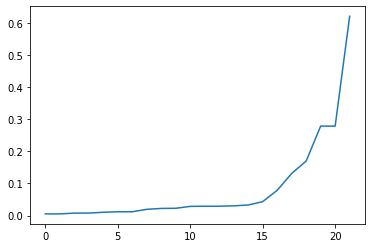

In [28]:
neigh = NearestNeighbors(n_neighbors = 2).fit(X.loc[:,["x_gaze","y_gaze"]])
dist,inds = neigh.kneighbors(X.loc[:,["x_gaze","y_gaze"]])
distances = np.sort(dist,axis = 0)[:,1]
plt.plot(distances)

<AxesSubplot:xlabel='x_gaze', ylabel='y_gaze'>

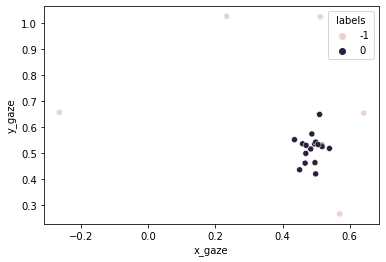

In [60]:
dbscan = DBSCAN(eps = 0.1,min_samples = 10).fit(X.loc[:,["x_gaze","y_gaze"]])
X["labels"] = dbscan.labels_
sns.scatterplot(X.x_gaze,X.y_gaze, hue = X["labels"])

Film/gaze data visualization.

In [71]:
# stop/start stills to figure out vid content within each section
film_stills_dir = r"C:\Users\luzia.troebinger\CortEx\film_stills"
stills = os.listdir(film_stills_dir)
save = 0
if save:
    output_dir = os.path.join(os.getcwd(),"stills_start_end" )
    for i, frame in enumerate(frame_nums):                                                                         
        img = Image.open(os.path.join(film_stills_dir, stills[frame[0]]))   
        img.save(os.path.join(output_dir, ''.join(['sec_'+str(i)+'_start_frame.png'])))
        img = Image.open(os.path.join(film_stills_dir, stills[frame[1]]))
        img.save(os.path.join(output_dir, ''.join(['sec_'+str(i)+'_end_frame.png'])))

In [101]:
overlay_dir = os.path.join(rawfilepath, "film_stills_woverlay")
try:
    os.mkdir(overlay_dir)
except OSError:
    pass
    
for i, still in enumerate(stills[:-1]):
    fig,ax = plt.subplots()
    img = plt.imread(os.path.join(film_stills_dir,still))
    sns.kdeplot(ax = ax, x = gaze_x.loc[i,:]*img.shape[1], y = gaze_y.loc[i,:]*img.shape[0], fill = True)
    ax.axis("off")
    ax.imshow(img)
    fig.savefig(os.path.join(overlay_dir, "_".join([still, "overlay.jpg"])))
    plt.close()


https://hamelot.io/visualization/using-ffmpeg-to-convert-a-set-of-images-into-a-video/

In [13]:
# intrusions data
intrusions_df = pd.read_csv(os.path.join(intrusions_dir, 'qualtrics_study_day.csv'))
# drop incomplete
intrusions_df = intrusions_df[intrusions_df.Finished == 'TRUE']
substring_filter = ['DQ-1','Q196','Q195']
intrusions_df = substring_in_df_col(intrusions_df, substring_filter)
intrusions_df = intrusions_df[intrusions_df['DQ-1'].astype('float')<100]
intrusions_df = intrusions_df.replace('0',np.nan)
intrusions_df = intrusions_df.dropna(how = 'all', axis = 0)
intrusions_df = intrusions_df.dropna(how = 'all',axis = 1)

